<a href="https://colab.research.google.com/github/Mohammed70S/pytorch/blob/main/Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64
Epoch [100/1000], Loss: 0.9243
Epoch [200/1000], Loss: 0.8549
Epoch [300/1000], Loss: 0.7511
Epoch [400/1000], Loss: 0.6190
Epoch [500/1000], Loss: 0.4877
Epoch [600/1000], Loss: 0.3893
Epoch [700/1000], Loss: 0.3331
Epoch [800/1000], Loss: 0.3107
Epoch [900/1000], Loss: 0.2909
Epoch [1000/1000], Loss: 0.2838
Shape of y_pred_test: torch.Size([82, 1])
Shape of y_test_np: (82, 1)
Test Loss (MSE): 874656.1250
Mean Absolute Error (MAE): 874656.1250
R-squared (R²): 0.6763
Accuracy: 0.7683
Precision: 0.6734
Recall: 0.7683


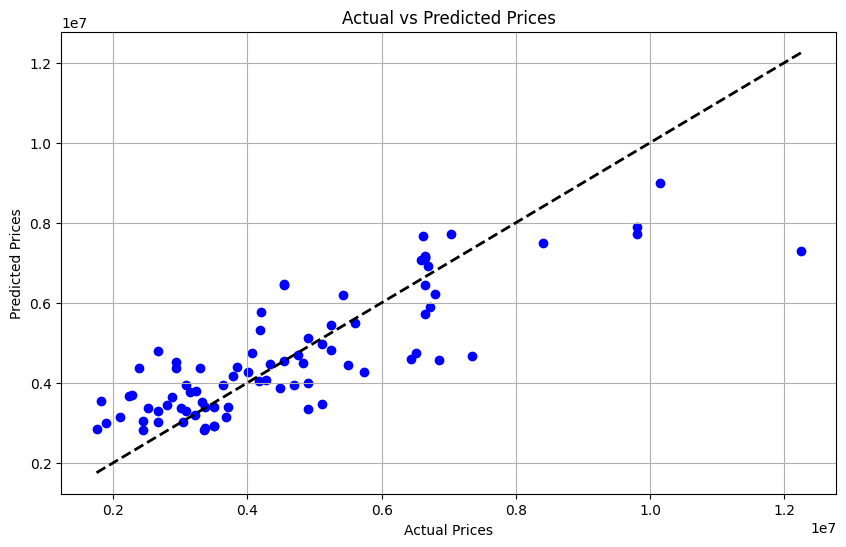

In [41]:
# Step 1: Load the necessary libraries and dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score

# Load the dataset
file_path = 'Housing-1.xlsx'  # Change to the path where your file is located
data = pd.read_excel(file_path)

# Step 2: Preprocess the data
# Check for missing values
print(data.isnull().sum())

# Convert Yes/No to 1/0 in specified columns
binary_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
data[binary_columns] = data[binary_columns].apply(lambda x: x.map({'yes': 1, 'no': 0}))

# One-Hot Encoding for 'furnishingstatus'
data = pd.get_dummies(data, columns=['furnishingstatus'], drop_first=True)

# Define feature columns and target column
X = data.drop(columns=['price'])
y = data['price'].values.reshape(-1, 1)

# Normalize the feature columns and the target (price)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Split data into training and test sets (80% train, 15% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.15, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Step 3: Define the ANN model with more layers
class ANNModel(nn.Module):
    def __init__(self, input_size):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)    # New layer
        self.fc4 = nn.Linear(64, 16)    # New layer
        self.fc5 = nn.Linear(16, 1)     # Output layer
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))     # Forward through new layer
        x = torch.relu(self.fc4(x))     # Forward through new layer
        x = self.fc5(x)
        return x

# Initialize the model with the updated architecture
input_size = X_train_tensor.shape[1]
model = ANNModel(input_size)

# Step 4: Define Loss function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)  # Adjusted learning rate

# Step 5: Train the model
epochs = 1000
train_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    train_losses.append(loss.item())

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Step 6: Evaluate the model using MSE, MAE, and R-squared
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)  # Prediction using the test set
    y_pred_test_np = y_pred_test.numpy()  # Convert predictions to numpy for metric calculations
    y_test_np = y_test_tensor.numpy()     # Convert actual values to numpy

# Check shapes for validation
print("Shape of y_pred_test:", y_pred_test.shape)
print("Shape of y_test_np:", y_test_np.shape)

# Inverse transform the predicted and actual values to original scale
y_pred_test_original = scaler_y.inverse_transform(y_pred_test_np)
y_test_original = scaler_y.inverse_transform(y_test_np)

# MSE Calculation
mse = mean_absolute_error(y_test_original, y_pred_test_original)
print(f'Test Loss (MSE): {mse:.4f}')

# MAE Calculation
mae = mean_absolute_error(y_test_original, y_pred_test_original)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

# R-squared Calculation
r_squared = r2_score(y_test_original, y_pred_test_original)
print(f'R-squared (R²): {r_squared:.4f}')

# Step 7: Classification Metrics
# Define thresholds for classification (e.g., low, medium, high prices)
threshold_low = y_test_original.mean() - y_test_original.std()
threshold_high = y_test_original.mean() + y_test_original.std()

# Create binary classification labels based on thresholds
y_test_classes = []
y_pred_classes = []

for actual in y_test_original:
    if actual < threshold_low:
        y_test_classes.append(0)  # Low
    elif actual > threshold_high:
        y_test_classes.append(2)  # High
    else:
        y_test_classes.append(1)  # Medium

for pred in y_pred_test_original:
    if pred < threshold_low:
        y_pred_classes.append(0)  # Low
    elif pred > threshold_high:
        y_pred_classes.append(2)  # High
    else:
        y_pred_classes.append(1)  # Medium

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted', zero_division=0)
recall = recall_score(y_test_classes, y_pred_classes, average='weighted', zero_division=0)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Step 8: Plot actual vs predicted prices for the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_test_original, color='blue')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'k--', lw=2)
plt.grid(True)

# Save the plot as a PNG file
plt.savefig('actual_vs_predicted_prices.png', format='png')
plt.show()